## Weather Forecaster
#### Alex Sessums
#### 12 August 2022

In [1]:
# Data Analysis
import numpy as np
import pandas as pd
import sqldf as sqldf

# Data Viz
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
import plotly.express as px

# ML
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose as sd
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.ar_model import ar_select_order
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.ar_model import ar_select_order, AutoReg
import statsmodels
from statsmodels.tsa import stattools
from statsmodels.tsa.arima.model import ARIMA

# Miscellaneous
import os
import datetime
from datetime import timedelta
import pmdarima as pm
from datetime import date
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load Data from Text File into Dataframe
df = pd.read_csv('data/TG_STAID002759.txt', parse_dates=True, index_col=1)
df = df.reset_index()
df.head(6)

,DATE,SOUID,TG,Q_TG
0,1876-01-01,127488,22,0
1,1876-01-02,127488,25,0
2,1876-01-03,127488,3,0
3,1876-01-04,127488,-58,0
4,1876-01-05,127488,-98,0
5,1876-01-06,127488,-77,0


In [3]:
# Quick data exploration
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53507 entries, 0 to 53506
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0       DATE  53507 non-null  datetime64[ns]
 1   SOUID     53507 non-null  int64         
 2      TG     53507 non-null  int64         
 3    Q_TG     53507 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 1.6 MB


In [4]:
# Dataframe modification - Rename columns, drop useless features, mutliply celsius by .1
df.columns=['date', 'squid', 'temp', 'q_tg']
df.drop(['squid', 'q_tg'], axis=1, inplace=True)
df['temp'] = df['temp'] * 0.1
df['date'] = pd.to_datetime(df['date'])
df.head(6)

,date,temp
0,1876-01-01,2.2
1,1876-01-02,2.5
2,1876-01-03,0.3
3,1876-01-04,-5.8
4,1876-01-05,-9.8
5,1876-01-06,-7.7


## EDA

In [5]:
# Create new date featurees
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['day'] = df['date'].dt.day
df.head(6)

,date,temp,month,year,day
0,1876-01-01,2.2,1,1876,1
1,1876-01-02,2.5,1,1876,2
2,1876-01-03,0.3,1,1876,3
3,1876-01-04,-5.8,1,1876,4
4,1876-01-05,-9.8,1,1876,5
5,1876-01-06,-7.7,1,1876,6


<AxesSubplot:xlabel='date', ylabel='temp'>

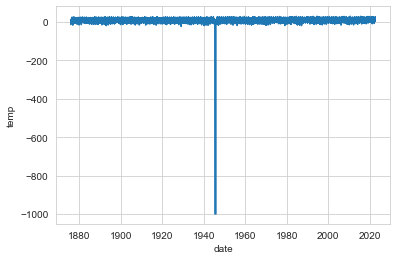

In [6]:
# Quick line-plot of all values shows dummy values (-9999) in 1945
sns.lineplot(x = "date", y = "temp", data=df)

In [7]:
# Create a new DF, dropping data before 1945 due to missing values
df = df[df["year"] > 1945].reset_index(drop=True)
df.head()

,date,temp,month,year,day
0,1946-01-01,-3.4,1,1946,1
1,1946-01-02,-3.0,1,1946,2
2,1946-01-03,-2.8,1,1946,3
3,1946-01-04,-2.7,1,1946,4
4,1946-01-05,1.4,1,1946,5


In [8]:
# Split train and test data
df_train = df[:-365]
df_test = df[-365:]

In [9]:
# Define plot weather

def plot(x, y, df):
    fig = df.plot.line(x=x, y=x, figsize=[18,5])
    min_year = df['year'].min()
    max_year = df['year'].max()
    plt.xlabel('Date', fontsize=10)
    plt.ylabel('Temperature (Celsius)', fontsize=10)
    plt.suptitle(f'Temperature (°C) Readings from {min_year} to {max_year} at Berlin-Tempelhof', fontsize = 13)

Text(0.5, 0.98, 'Temperature (°C) Readings from 1946 to 2022 at Berlin-Tempelhof')

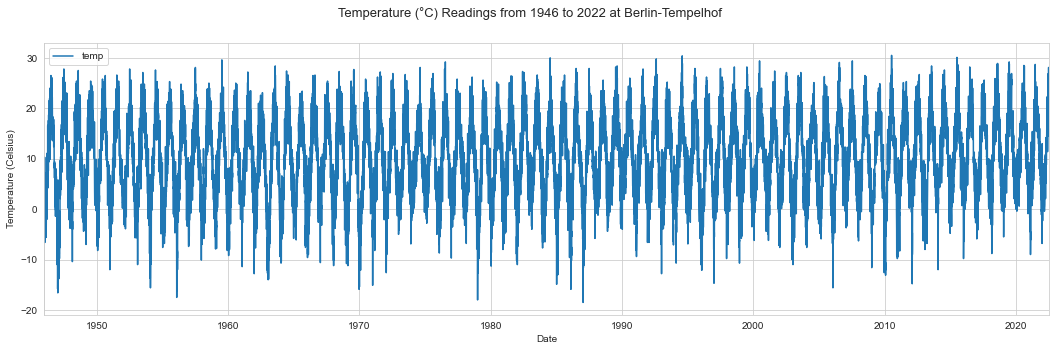

In [10]:
# Plot Temperature in Celsius from beginning to end of abbreviated time period
fig = df.plot.line(x='date', y='temp', figsize=[18,5])
min_year = df['year'].min()
max_year = df['year'].max()

plt.xlabel('Date', fontsize=10)
plt.ylabel('Temperature (Celsius)', fontsize=10)
plt.suptitle(f'Temperature (°C) Readings from {min_year} to {max_year} at Berlin-Tempelhof', fontsize = 13)

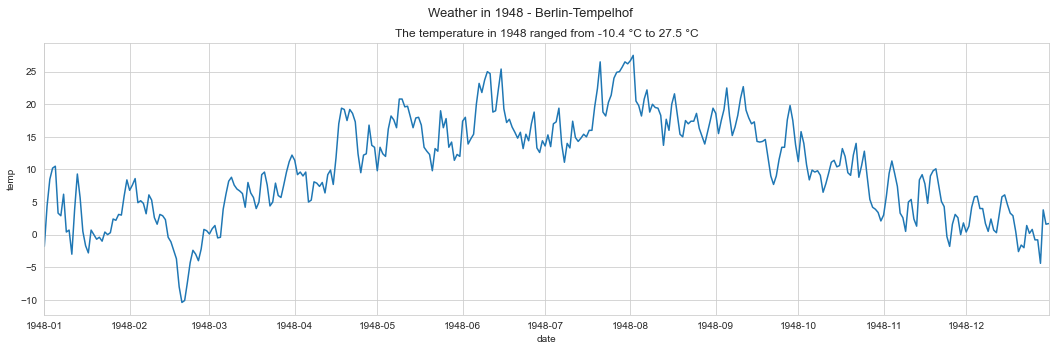

In [11]:
# Plot an early year
fig, ax = plt.subplots(figsize=[18,5])
data_plot = df.loc[df['year']==1948]
title = data_plot['year'].iloc[0]
min_temp = data_plot['temp'].min()
max_temp = data_plot['temp'].max()

sns.lineplot(x = "date", y = "temp", data=data_plot, ax=ax)
ax.set_xlim(data_plot['date'].min(), data_plot['date'].max())
plt.suptitle(f'Weather in {title} - Berlin-Tempelhof', fontsize = 13)
plt.title(f'The temperature in {title} ranged from {min_temp} °C to {max_temp} °C', fontsize = 12)
plt.show()

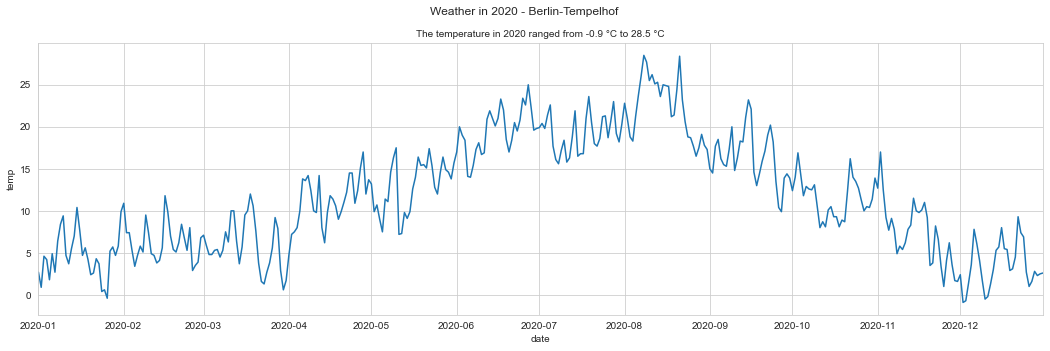

In [12]:
# Plot a recent year
fig, ax = plt.subplots(figsize=[18,5])
data_plot = df.loc[df['year']==2020]
title = data_plot['year'].iloc[0]
min_temp = data_plot['temp'].min()
max_temp = data_plot['temp'].max()

sns.lineplot(x = "date", y = "temp", data=data_plot, ax=ax)
ax.set_xlim(data_plot['date'].min(), data_plot['date'].max())
plt.suptitle(f'Weather in {title} - Berlin-Tempelhof', fontsize = 12)
plt.title(f'The temperature in {title} ranged from {min_temp} °C to {max_temp} °C', fontsize = 10)
plt.show()

In [13]:
# Plotly graph
fig = px.line(df, x=df['date'], y="temp")
fig.update_xaxes(rangeslider_visible=True)

## Model Trend - Linear Regression

In [14]:
# Model the trend
df_train['timestep'] = list(range(len(df_train)))
df_train.set_index('date')
df_train.head()

,date,temp,month,year,day,timestep
0,1946-01-01,-3.4,1,1946,1,0
1,1946-01-02,-3.0,1,1946,2,1
2,1946-01-03,-2.8,1,1946,3,2
3,1946-01-04,-2.7,1,1946,4,3
4,1946-01-05,1.4,1,1946,5,4


In [15]:
# Linear Regression

X_trend = df_train[['timestep']]
y_trend = df_train[['temp']]

m = LinearRegression()

m.fit(X_trend, y_trend)

LinearRegression()

In [16]:
df_train['trend'] = m.predict(X_trend)

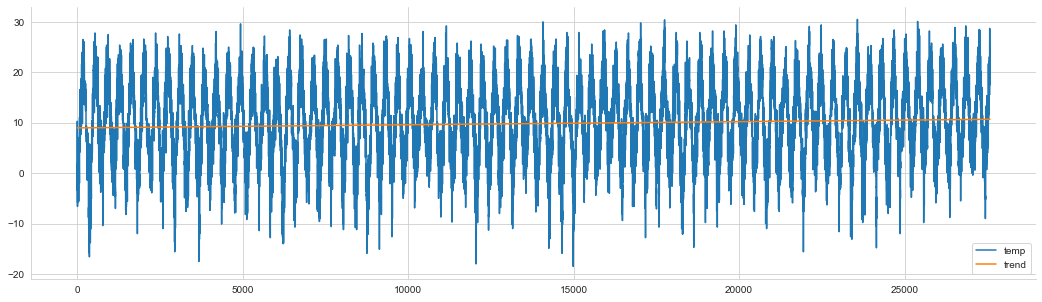

In [17]:
# Temp and Trend
df_train[['temp','trend']].plot(figsize=(18,5),legend=True)
sns.despine()

## Decomposition

In [18]:
# Subtract trend from temperature to produce detrended values
df_train['detrended'] = df_train['temp'] - df_train['trend']
df_train.head()

,date,temp,month,year,day,timestep,trend,detrended
0,1946-01-01,-3.4,1,1946,1,0,8.979862,-12.379862
1,1946-01-02,-3.0,1,1946,2,1,8.979924,-11.979924
2,1946-01-03,-2.8,1,1946,3,2,8.979985,-11.779985
3,1946-01-04,-2.7,1,1946,4,3,8.980047,-11.680047
4,1946-01-05,1.4,1,1946,5,4,8.980109,-7.580109


In [19]:
# Make dummy columns for months for new weather dataframe

seasonal_dummies = pd.get_dummies(
    df_train['month'], 
    prefix='month', 
    drop_first=True
).set_index(df_train.index)

# encode dummy columns to our weather dataset
weather = pd.concat([df_train, seasonal_dummies], axis=1)
weather.tail()

,date,temp,month,year,day,timestep,trend,detrended,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
27570,2021-06-26,21.5,6,2021,26,27570,10.682571,10.817429,0,0,0,0,1,0,0,0,0,0,0
27571,2021-06-27,22.1,6,2021,27,27571,10.682633,11.417367,0,0,0,0,1,0,0,0,0,0,0
27572,2021-06-28,25.3,6,2021,28,27572,10.682695,14.617305,0,0,0,0,1,0,0,0,0,0,0
27573,2021-06-29,24.1,6,2021,29,27573,10.682756,13.417244,0,0,0,0,1,0,0,0,0,0,0
27574,2021-06-30,18.2,6,2021,30,27574,10.682818,7.517182,0,0,0,0,1,0,0,0,0,0,0


In [20]:
X_seasonality = weather[weather.columns[-11:]]
y_seasonality = weather['detrended']

In [21]:
# Fit the seasonality model
seasonality_model = LinearRegression()
seasonality_model.fit(X_seasonality, y_seasonality)

LinearRegression()

In [22]:
# Predict from fitted model
weather['seasonality_pred'] = seasonality_model.predict(X_seasonality)

In [23]:
weather.head()

,date,temp,month,year,day,timestep,trend,detrended,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,seasonality_pred
0,1946-01-01,-3.4,1,1946,1,0,8.979862,-12.379862,0,0,0,0,0,0,0,0,0,0,0,-9.452839
1,1946-01-02,-3.0,1,1946,2,1,8.979924,-11.979924,0,0,0,0,0,0,0,0,0,0,0,-9.452839
2,1946-01-03,-2.8,1,1946,3,2,8.979985,-11.779985,0,0,0,0,0,0,0,0,0,0,0,-9.452839
3,1946-01-04,-2.7,1,1946,4,3,8.980047,-11.680047,0,0,0,0,0,0,0,0,0,0,0,-9.452839
4,1946-01-05,1.4,1,1946,5,4,8.980109,-7.580109,0,0,0,0,0,0,0,0,0,0,0,-9.452839


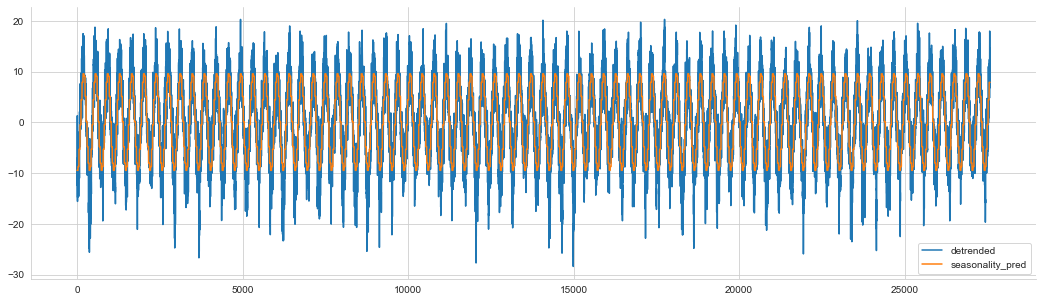

In [24]:
# Plot the detrended data plus predictions
weather[['detrended','seasonality_pred']].plot(figsize=(18,5),legend=True)
sns.despine()

In [25]:
# Combine trend and seasonality
weather['trend_seasonal'] = weather['trend'] + weather['seasonality_pred']

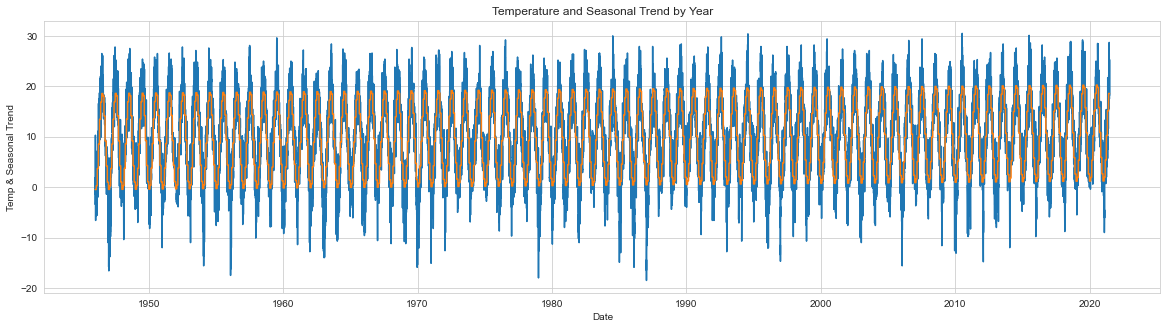

In [26]:
# Define plot space
fig, ax = plt.subplots(figsize=(20, 5))

# Define x and y axes
ax.plot(weather['date'], 
        weather[['temp', 'trend_seasonal']])

# Set plot title and axes labels
ax.set(title = "Temperature and Seasonal Trend by Year",
       xlabel = "Date",
       ylabel = "Temp & Seasonal Trend")

plt.show()

## Extracting the Remainder

In [27]:
# Leftover time series devoid of trend and seasonality
weather['remainder'] = weather['temp'] - weather['trend_seasonal']
weather['temp'] = df['temp']

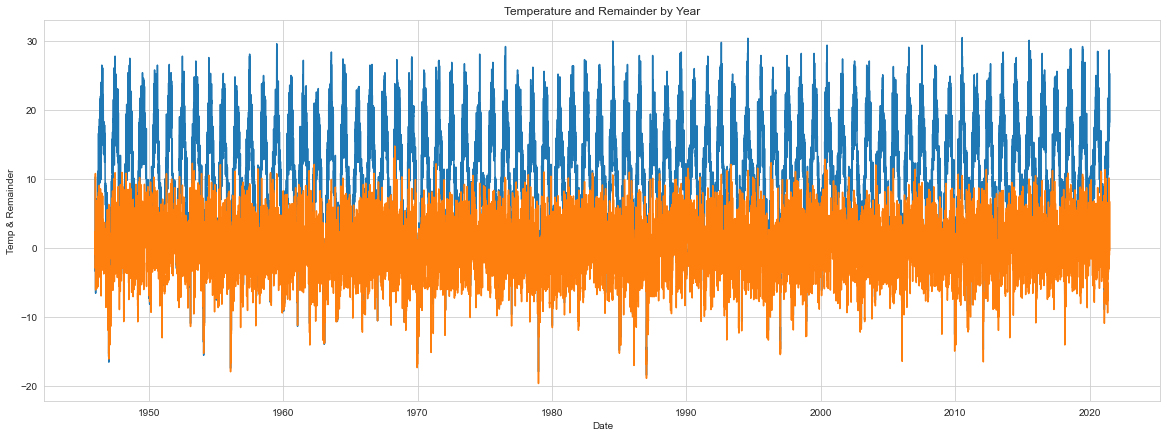

In [28]:
# Define plot space
fig, ax = plt.subplots(figsize=(20, 7))

# Define x and y axes
ax.plot(weather['date'], 
        weather[['temp', 'remainder']])

# Set plot title and axes labels
ax.set(title = "Temperature and Remainder by Year",
       xlabel = "Date",
       ylabel = "Temp & Remainder")

plt.show()

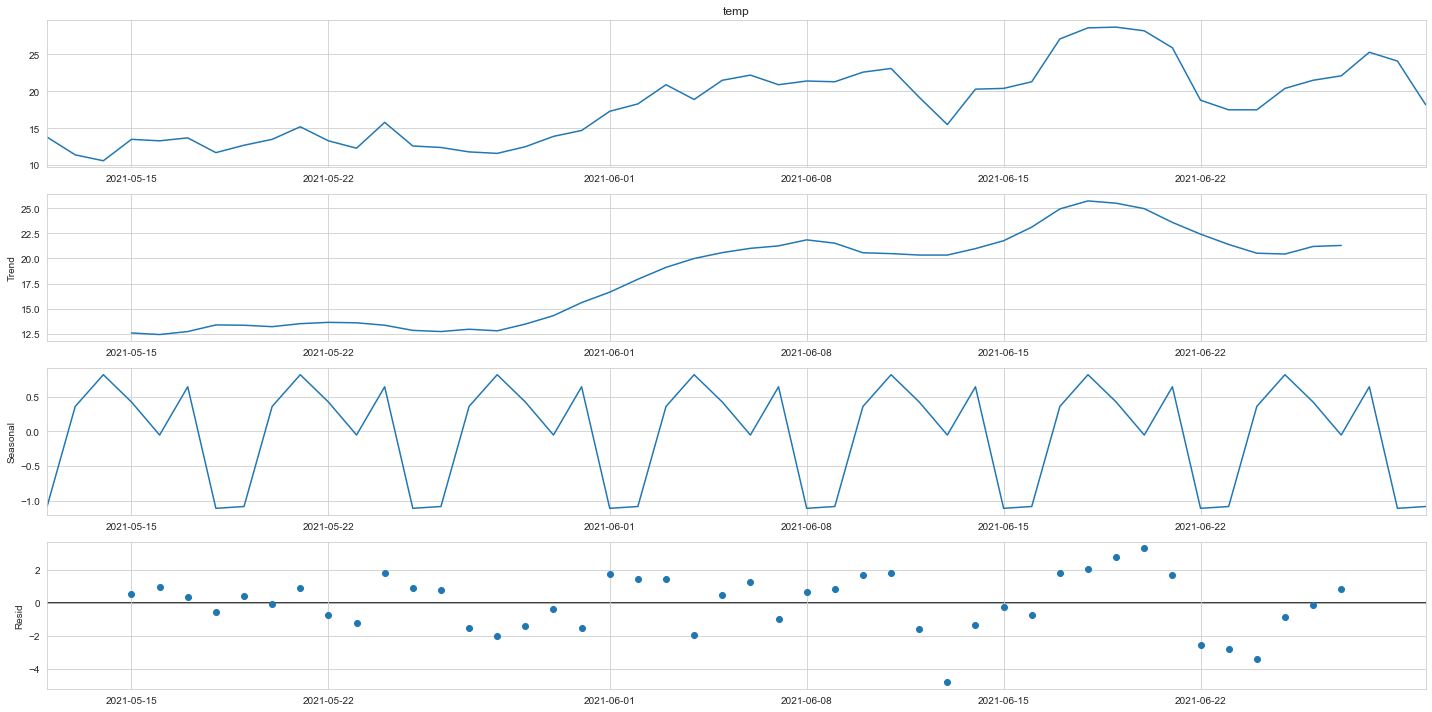

In [29]:
# temp with additive plots: trend, seasonal, residual
weather_additive = weather.set_index('date')

sd = sd(weather_additive['temp'].iloc[-50:], model='additive')

plt.rcParams['figure.figsize'] = (20,10)
sd.plot()
None

In [30]:
# Save the remainder in a .csv file in current working directory
cwd = os.getcwd()
exportDate = date.today().strftime("%Y_%m_%d")

df_remainder = weather[['date', 'temp','remainder', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11']]
df_remainder.to_csv(f'weather_remainder_{exportDate}.csv',index=False)

## Modelling

In [31]:
# Import the remainder as a CSV
df = pd.read_csv(f'weather_remainder_{exportDate}.csv')
df['lag1'] = df['remainder'].shift(1)
df['lag2'] = df['remainder'].shift(2)
df['lag3'] = df['remainder'].shift(3)
df.dropna(inplace=True)
df.tail()

,date,temp,remainder,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,lag1,lag2,lag3
27570,2021-06-26,21.5,2.915186,0,0,0,0,1,0,0,0,0,0,1.815248,-1.084690,-1.084629
27571,2021-06-27,22.1,3.515124,0,0,0,0,1,0,0,0,0,0,2.915186,1.815248,-1.084690
27572,2021-06-28,25.3,6.715063,0,0,0,0,1,0,0,0,0,0,3.515124,2.915186,1.815248
27573,2021-06-29,24.1,5.515001,0,0,0,0,1,0,0,0,0,0,6.715063,3.515124,2.915186
27574,2021-06-30,18.2,-0.385061,0,0,0,0,1,0,0,0,0,0,5.515001,6.715063,3.515124


## Run the Full Model

In [32]:
# Assign X
X_full = df.drop(columns=['date', 'temp', 'remainder'])
y_full = df['temp']

In [33]:
# Train the model
m_full = LinearRegression()
m_full.fit(X_full, y_full)

LinearRegression()

In [34]:
# Create a new predictions column
df['predictions_full_model'] = m_full.predict(X_full)
df['date'] = pd.to_datetime(df['date'])
df.tail()

,date,temp,remainder,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,lag1,lag2,lag3,predictions_full_model
27570,2021-06-26,21.5,2.915186,0,0,0,0,1,0,0,0,0,0,1.815248,-1.084690,-1.084629,19.537079
27571,2021-06-27,22.1,3.515124,0,0,0,0,1,0,0,0,0,0,2.915186,1.815248,-1.084690,19.958105
27572,2021-06-28,25.3,6.715063,0,0,0,0,1,0,0,0,0,0,3.515124,2.915186,1.815248,20.503441
27573,2021-06-29,24.1,5.515001,0,0,0,0,1,0,0,0,0,0,6.715063,3.515124,2.915186,23.427151
27574,2021-06-30,18.2,-0.385061,0,0,0,0,1,0,0,0,0,0,5.515001,6.715063,3.515124,21.699578


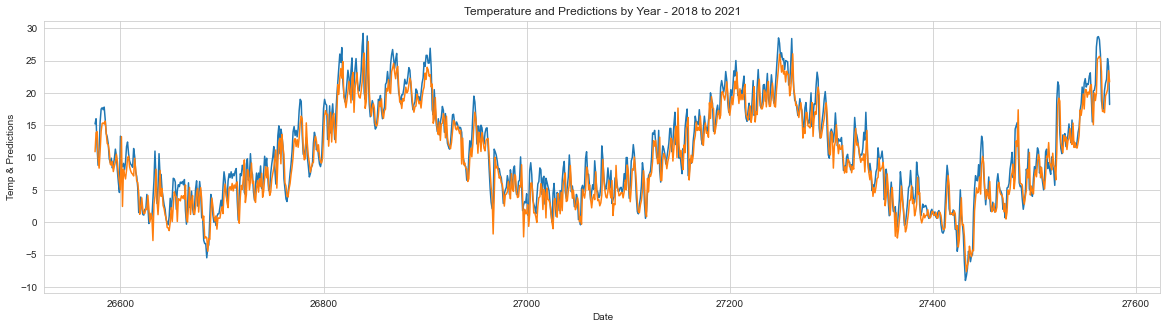

In [35]:
# Plot predictions
fig, ax = plt.subplots(figsize=(20, 5))

# Define x and y axes
df_plot = df[-1000:]
min_year_plot = df_plot['date'].dt.year.min()
max_year_plot = df_plot['date'].dt.year.max()
ax.plot(df_plot[['temp', 'predictions_full_model']])

# Set plot title and axes labels
ax.set(title = f'Temperature and Predictions by Year - {min_year_plot} to {max_year_plot}',
       xlabel = "Date",
       ylabel = "Temp & Predictions")

plt.show()

## Forecasts

In [36]:
df.head()

,date,temp,remainder,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,lag1,lag2,lag3,predictions_full_model
3,1946-01-04,-2.7,-2.227208,0,0,0,0,0,0,0,0,0,0,-2.327147,-2.527085,-2.927023,-0.738333
4,1946-01-05,1.4,1.872730,0,0,0,0,0,0,0,0,0,0,-2.227208,-2.327147,-2.527085,-0.657139
5,1946-01-06,1.9,2.372668,0,0,0,0,0,0,0,0,0,0,1.872730,-2.227208,-2.327147,3.136650
6,1946-01-07,0.4,0.872606,0,0,0,0,0,0,0,0,0,0,2.372668,1.872730,-2.227208,2.761523
7,1946-01-08,-1.4,-0.927456,0,0,0,0,0,0,0,0,0,0,0.872606,2.372668,1.872730,1.574040


In [37]:
timestep = df['date'].iloc[-1] + timedelta(days=1)
months = [0] * 11
#lag_1 = df_combi.loc['2022-06-30', 'remainder']
#lag_2 = df_combi.loc['2020-06-29', 'remainder']
lag_1 = 2.816883
lag_2 = 0.904454

In [38]:
lags =[lag_1,lag_2]

In [39]:
timestep, months, lags

(Timestamp('2021-07-01 00:00:00'),
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [2.816883, 0.904454])

In [40]:
X_future = [timestep]

In [41]:
X_future.extend(months)
X_future

[Timestamp('2021-07-01 00:00:00'), 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [42]:
X_future.append(lag_1)
X_future

[Timestamp('2021-07-01 00:00:00'), 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.816883]

In [43]:
X_future.append(lag_2)
X_future

[Timestamp('2021-07-01 00:00:00'),
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2.816883,
 0.904454]

In [44]:
type(X_future)

list

In [45]:
X_combi = df.drop(columns=['date','predictions_full_model', 'temp', 'remainder', 'lag3'])
y_combi = df['temp']

In [46]:
X_combi.columns

Index(['month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'lag1', 'lag2'],
      dtype='object')

In [47]:
X_future = pd.DataFrame([X_future])

In [48]:
X_future.drop(columns=[0, 1], axis=1, inplace=True)

In [49]:
X_future.columns

Int64Index([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], dtype='int64')

In [50]:
X_combi.columns

Index(['month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'lag1', 'lag2'],
      dtype='object')

In [51]:
# X_future = pd.DataFrame([X_future])
X_future.columns = X_combi.columns

X_future

,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,lag1,lag2
0,0,0,0,0,0,0,0,0,0,0,2.816883,0.904454


In [52]:
X_combi

,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,lag1,lag2
3,0,0,0,0,0,0,0,0,0,0,-2.327147,-2.527085
4,0,0,0,0,0,0,0,0,0,0,-2.227208,-2.327147
5,0,0,0,0,0,0,0,0,0,0,1.872730,-2.227208
6,0,0,0,0,0,0,0,0,0,0,2.372668,1.872730
7,0,0,0,0,0,0,0,0,0,0,0.872606,2.372668
...,...,...,...,...,...,...,...,...,...,...,...,...
27570,0,0,0,0,1,0,0,0,0,0,1.815248,-1.084690
27571,0,0,0,0,1,0,0,0,0,0,2.915186,1.815248
27572,0,0,0,0,1,0,0,0,0,0,3.515124,2.915186
27573,0,0,0,0,1,0,0,0,0,0,6.715063,3.515124


In [53]:
y_combi

3        -2.7
4         1.4
5         1.9
6         0.4
7        -1.4
         ... 
27570    21.5
27571    22.1
27572    25.3
27573    24.1
27574    18.2
Name: temp, Length: 27572, dtype: float64

In [54]:
m_combi = LinearRegression()
m_combi.fit(X_combi, y_combi)

LinearRegression()

In [55]:
m_combi.predict(X_future)

array([3.56878518])

## Model Evaluation

In [56]:
ts_split = TimeSeriesSplit(n_splits=5)

In [57]:
for i, (train_index, validation_index) in enumerate(ts_split.split(X_full, y_full)):
    print(f"""The training data for the {i+1}th iteration are the observations steps 
    {train_index}""")
    print(f"""The validation data for the {i+1}th iteration are the observations steps
    {validation_index}""")
    print('\n')

The training data for the 1th iteration are the observations steps 
    [   0    1    2 ... 4594 4595 4596]
The validation data for the 1th iteration are the observations steps
    [4597 4598 4599 ... 9189 9190 9191]


The training data for the 2th iteration are the observations steps 
    [   0    1    2 ... 9189 9190 9191]
The validation data for the 2th iteration are the observations steps
    [ 9192  9193  9194 ... 13784 13785 13786]


The training data for the 3th iteration are the observations steps 
    [    0     1     2 ... 13784 13785 13786]
The validation data for the 3th iteration are the observations steps
    [13787 13788 13789 ... 18379 18380 18381]


The training data for the 4th iteration are the observations steps 
    [    0     1     2 ... 18379 18380 18381]
The validation data for the 4th iteration are the observations steps
    [18382 18383 18384 ... 22974 22975 22976]


The training data for the 5th iteration are the observations steps 
    [    0     1     2 ...

In [58]:
time_series_split = ts_split.split(X_full, y_full)

In [59]:
result = cross_val_score(estimator=m_full, 
                         X=X_full, y=y_full,
                         cv=time_series_split)
result

array([0.91392194, 0.90548113, 0.90037314, 0.90611934, 0.90522011])

In [60]:
result.mean()

0.9062231305604875

In [61]:
def print_adf(df_train):
    adf_stats, p, used_lag, n_obs, levels, information_criterion = \
            statsmodels.tsa.stattools.adfuller(df_train)
    
    print(f"""adf_stats: {adf_stats}
            p: {p} 
            used lag: {used_lag} 
            number of observations: {n_obs}
            CI 99%: {levels['1%']}
            CI 95%: {levels['5%']}
            CI 90%: {levels['10%']}
            information criterion (AIC): {information_criterion}
            """) 

## ARIMA Model

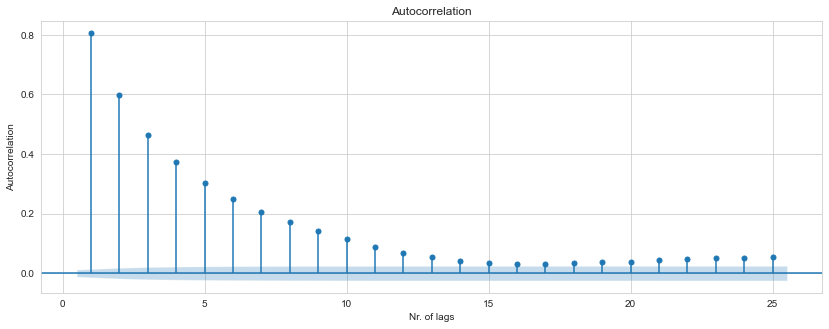

In [62]:
# plot autocorrelation function
plt.rcParams['figure.figsize'] = (14,5)
plot_acf(df['remainder'],zero=False,lags=25)
plt.xlabel('Nr. of lags')
plt.ylabel('Autocorrelation')
None

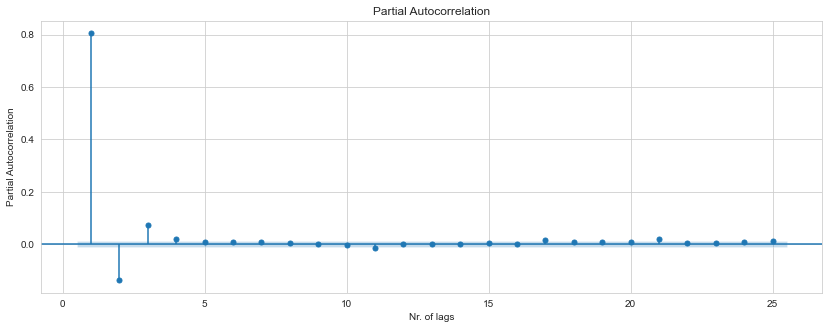

In [63]:
# Plot partial autocorrelation function
plot_pacf(df['remainder'],zero=False,lags=25)
plt.xlabel('Nr. of lags')
plt.ylabel('Partial Autocorrelation')
None

In [64]:
ar_model = AutoReg(endog=df['remainder'], lags=1).fit()

In [65]:
df['ar_prediction'] = ar_model.predict()

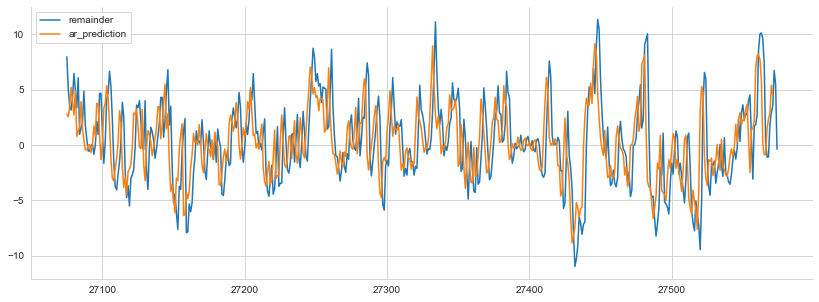

In [66]:
df_plot = df[-500:]
df_plot[['remainder', 'ar_prediction']].plot(figsize=(14,5),legend=True)
sns.despine()

In [67]:
df['trend_seasonal'] = weather['trend'] + weather['seasonality_pred']
df['full_prediction_ar'] = df['trend_seasonal'] + df['ar_prediction']

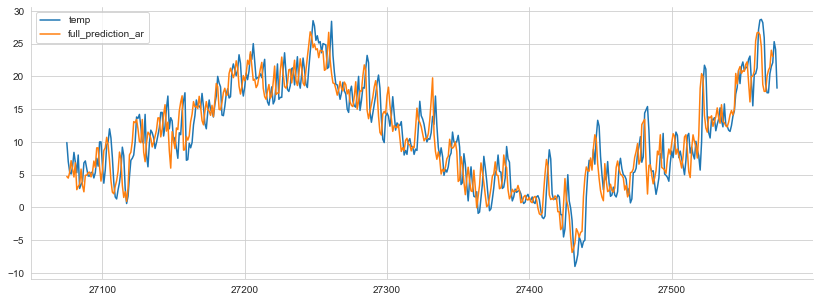

In [68]:
df_plot = df[-500:]
df_plot[['temp', 'full_prediction_ar']].plot(figsize=(14,5),legend=True)
sns.despine()

In [69]:
arima_model = ARIMA(df['remainder'], order=(1, 0, 1)).fit()

In [70]:
df['arima_prediction'] = arima_model.predict()

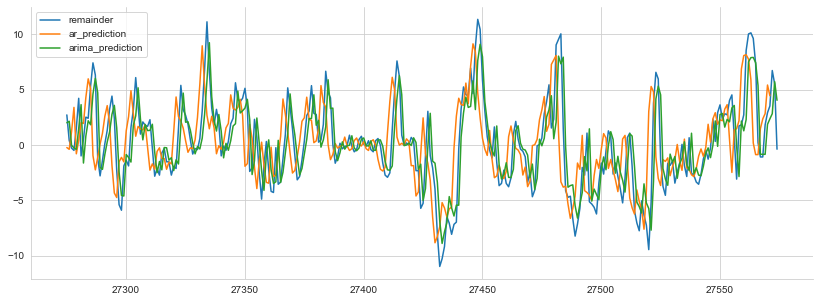

In [71]:
df_plot = df[-300:]
df_plot[['remainder', 'ar_prediction', 'arima_prediction']].plot(figsize=(14,5),legend=True)
sns.despine()

In [72]:
df['full_prediction_arima'] = df['trend_seasonal'] + df['arima_prediction']

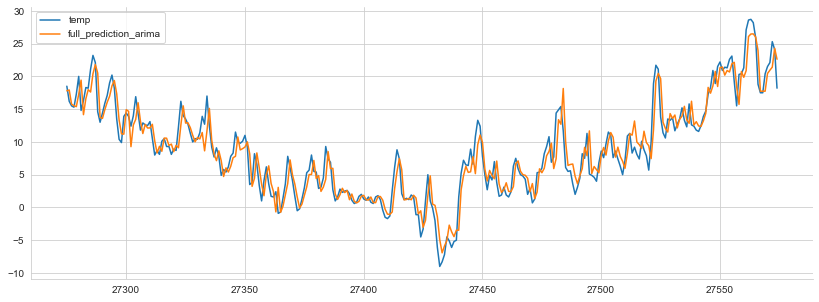

In [73]:
df_plot = df[-300:]
df_plot[['temp', 'full_prediction_arima']].plot(figsize=(14,5),legend=True)
sns.despine()

In [74]:
m = pm.auto_arima(df['remainder'], 
                  seasonal=False, 
                  maxiter=100, 
                  m=365, 
                  d=1,
                  D=1, 
                  n_jobs=-1, 
                  trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=18.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=128033.956, Time=0.36 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=128014.763, Time=0.75 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=128003.364, Time=1.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=128031.956, Time=0.31 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=13.26 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=126932.167, Time=1.96 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=15.01 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=126189.132, Time=2.99 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=26.76 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=125786.062, Time=5.35 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=30.90 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=125399.580, Time=8.22 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=inf, Time=36.73 sec
 ARIMA(0,1,5)(0,0,0)[0]             : AIC

In [75]:
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                27572
Model:               SARIMAX(0, 1, 5)   Log Likelihood              -62692.790
Date:                Sat, 13 Aug 2022   AIC                         125397.580
Time:                        17:52:47   BIC                         125446.928
Sample:                             0   HQIC                        125413.478
                              - 27572                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0628      0.006    -11.299      0.000      -0.074      -0.052
ma.L2         -0.2826      0.006    -50.239      0.000      -0.294      -0.272
ma.L3         -0.2174      0.006    -38.222      0.000      -0.229      -0.206
ma.L4         -0.1660      0.006    -29.198      0.000      -0.177      -0.155
ma.L5         -0.1307      0.006    -22.554      0.000      -0.142      -0.119
sigma2         5.5279      0.042    132.382      0.000       5.446       5.610
===================================================================================
Ljung-Box (L1) (Q):                   5.24   Jarque-Bera (JB):               476.56
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               0.89   Skew:                            -0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [76]:
df['full_prediction_autoarima'] = m.predict_in_sample()

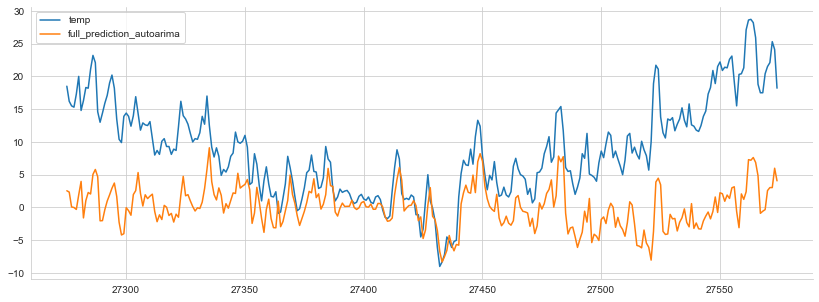

In [77]:
df_plot = df[-300:]
df_plot[['temp', 'full_prediction_autoarima']].plot(figsize=(14,5),legend=True)
sns.despine()

In [78]:
y_forecast, ci = m.predict(12, return_conf_int=True)

In [79]:
y_forecast

array([-0.89790769, -0.21297592,  0.35020291,  1.14981006,  1.73120793,
        1.73120793,  1.73120793,  1.73120793,  1.73120793,  1.73120793,
        1.73120793,  1.73120793])

In [80]:
timestamp = np.arange(len(df) + len(y_forecast))

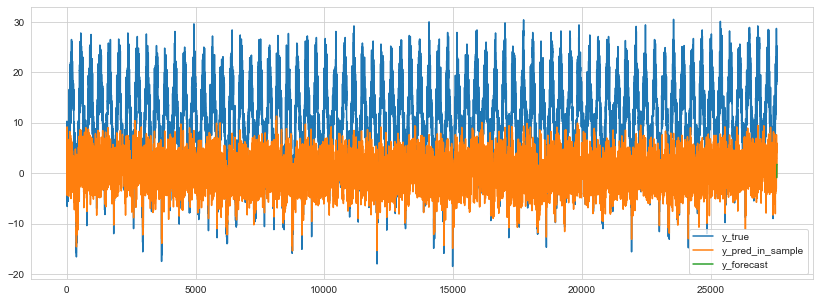

In [81]:
df_plot = df[-300:]
plt.plot(timestamp[:len(df)], df['temp'], label='y_true')
plt.plot(timestamp[:len(df)], df['full_prediction_autoarima'], label='y_pred_in_sample')
plt.plot(timestamp[len(df):], y_forecast, label='y_forecast')
plt.legend()
None

# ⭐ Facebook Prophet

In [82]:
from prophet import Prophet

In [83]:
df_prophet = pd.DataFrame()

In [84]:
df_prophet['y'] = df['temp']
df_prophet['ds'] = df['date']
df_prophet.tail()

,y,ds
27570,21.5,2021-06-26
27571,22.1,2021-06-27
27572,25.3,2021-06-28
27573,24.1,2021-06-29
27574,18.2,2021-06-30


In [85]:
pr = Prophet()
pr.fit(df_prophet)

17:52:49 - cmdstanpy - INFO - Chain [1] start processing
17:52:52 - cmdstanpy - INFO - Chain [1] done processing


In [86]:
future = pr.make_future_dataframe(periods=2)
zuckerberg = pr.predict(future)
print(zuckerberg)

              ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0     1946-01-04   9.419712   -4.253680    4.964812     9.419712     9.419712   
1     1946-01-05   9.420031   -4.964195    4.700284     9.420031     9.420031   
2     1946-01-06   9.420350   -4.645777    4.883763     9.420350     9.420350   
3     1946-01-07   9.420669   -4.613176    4.940769     9.420669     9.420669   
4     1946-01-08   9.420988   -5.071186    4.998046     9.420988     9.420988   
...          ...        ...         ...         ...          ...          ...   
27569 2021-06-28  11.372982   15.490116   24.989630    11.372982    11.372982   
27570 2021-06-29  11.373185   15.351669   24.967708    11.373185    11.373185   
27571 2021-06-30  11.373387   15.670760   24.908119    11.373387    11.373387   
27572 2021-07-01  11.373589   15.017358   24.729218    11.373589    11.373589   
27573 2021-07-02  11.373792   15.199036   25.023592    11.373792    11.373792   

       additive_terms  addi

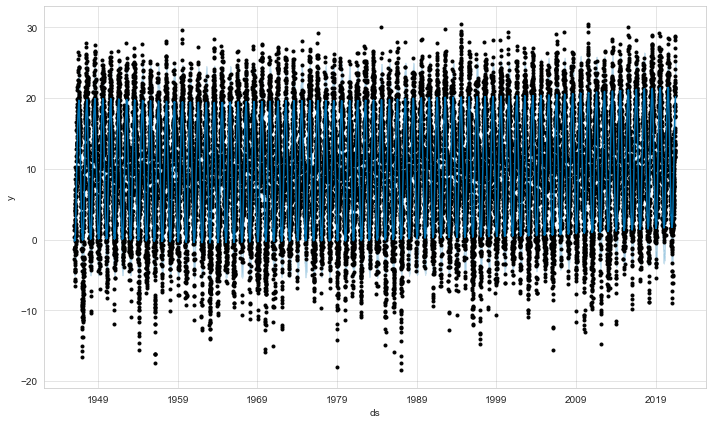

In [87]:
fig1 = pr.plot(zuckerberg)